In [1]:
# setup environment 
import os, glob
import numpy as np
import sklearn
from matplotlib import pyplot as plt

# Neural network
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor


In [2]:
# input data: read US image data
VideoName1GL = ["USImages_22DOF/IJ_GLvideo1_NewAdjunctions_*"]
CompressionRatio = 2
Folder =  'E:/ultrasound hand gesture recognition/10142023/'

Data = np.empty([0,int(300/CompressionRatio),int(500/CompressionRatio)]) # initiate data space
for MoveInd in VideoName1GL: 
    FileList = glob.glob(Folder+MoveInd)    # read ultrasound images, all images were save as 300 rows and 500 columns. shape = (300, 500)
    Data_temp = np.zeros((len(FileList), int(300/CompressionRatio),int(500/CompressionRatio))) 
    temp_ind = 0
    for iFile in FileList:
        # print(iFile)
        tempdata =  np.loadtxt(iFile, dtype = float, delimiter=",")
        Data_temp[temp_ind] = tempdata[::CompressionRatio,::CompressionRatio].reshape(1,150,250)
        temp_ind = temp_ind +1
    Data = np.concatenate((Data, Data_temp))


In [3]:
# output data
ModelOutput = np.empty([0,22])

HandFiles = ["IJ_new1029_adjunctions_22DOF_GL"]
for indHand in HandFiles:
    JointAngles = np.loadtxt(Folder+'Tracked data 22DOF/'+indHand+'.txt', dtype = float,delimiter=",")
    ModelOutput = np.concatenate((ModelOutput, JointAngles[:,1:]))

Data.shape, ModelOutput.shape


((2958, 150, 250), (2958, 22))

In [4]:
# Split dataset and preprocessing
from sklearn.model_selection import train_test_split

# X_train, X_test, Y_train, Y_test = train_test_split(USImagelist, ModelOutput, test_size=0.3, random_state=2)
X_train, X_test, Y_train, Y_test = train_test_split(Data, ModelOutput, test_size=0.7, random_state=2)

y_predict = np.zeros((len(X_test),Y_train.shape[1]))

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, y_predict.shape)

(887, 150, 250) (2071, 150, 250) (887, 22) (2071, 22) (2071, 22)


In [5]:
class HGDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.data = X
        self.modeloutput = Y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.modeloutput.shape[0]

    def __getitem__(self, idx):
        input = self.data[idx].astype(np.float32).reshape(1,Data.shape[1],Data.shape[2])
        output = self.modeloutput[idx].astype(np.float32)
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        return input, output

In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(HGDataset(X_train, Y_train), batch_size=batch_size);
test_dataloader = DataLoader(HGDataset(X_test, Y_test), batch_size=batch_size);

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}, {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 150, 250]), torch.float32
Shape of y: torch.Size([64, 22]) torch.float32


In [7]:
# Get cpu, gpu or mps device for training.
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
device = "cuda"
print(f"Using {device} device")


Using cuda device


In [8]:
class MultioutputCNN(nn.Module):
    def __init__(self, output_size=22):
        super(MultioutputCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1 channel, Output: 32 channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(140544, 128),  # Adjust the size here according to the output of the last MaxPool layer
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x
    
model_CNN = MultioutputCNN(output_size=22).to(device)
print(model_CNN)

loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model_CNN.parameters())

MultioutputCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=140544, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=22, bias=True)
  )
)


from torchvision.models import resnet18, ResNet18_Weights
modelResnet = resnet18()
print(modelResnet)
for name, child in modelResnet.named_children():
        for x, y in child.named_children():
            print(name,x)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        if batch % 10 == 0:
            loss, current = loss.to("cpu").detach().numpy(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, loss_ind, loss_value):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # loss = loss_fn(pred, y)
            test_loss += loss_fn(pred, y).item()*len(y)
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    # correct /= size
    # loss_value[loss_ind-1] = loss.detach().numpy()
    loss_value[loss_ind-1] = test_loss
    print("Loss in test: ")
    print(test_loss)
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Epoch 1
-------------------------------
loss: 144.847397  [   64/  887]
loss: 17.009304  [  704/  887]
Loss in test: 
14.17156080092168
Epoch 2
-------------------------------
loss: 14.170530  [   64/  887]
loss: 10.137915  [  704/  887]
Loss in test: 
9.246654157762881
Epoch 3
-------------------------------
loss: 9.107365  [   64/  887]
loss: 7.501460  [  704/  887]
Loss in test: 
7.307537325449695
Epoch 4
-------------------------------
loss: 7.540996  [   64/  887]
loss: 6.748428  [  704/  887]
Loss in test: 
6.592781921333302
Epoch 5
-------------------------------
loss: 6.715227  [   64/  887]
loss: 6.103050  [  704/  887]
Loss in test: 
6.093272826684264
Epoch 6
-------------------------------
loss: 6.188681  [   64/  887]
loss: 5.698215  [  704/  887]
Loss in test: 
5.6648777598404525
Epoch 7
-------------------------------
loss: 5.664508  [   64/  887]
loss: 5.437215  [  704/  887]
Loss in test: 
5.204942400014556
Epoch 8
-------------------------------
loss: 5.143150  [   64/

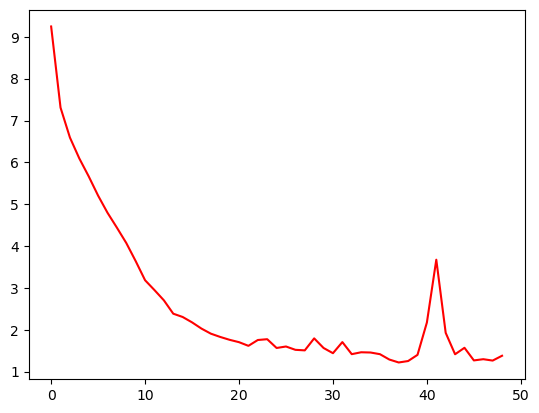

In [10]:
epochs = 50
loss_value = np.zeros(epochs)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_CNN, loss_fn, optimizer)
    test(test_dataloader, model_CNN, loss_fn, t, loss_value)
print("Done!")
# test(test_dataloader, model_CNN, loss_fn, t, loss_value)
plt.plot(range(epochs-1), loss_value[:-1], color ="red")

In [11]:
# use trained model to predict on test data

import time
ind_batch = 0
y_predict_CNN = np.zeros(y_predict.shape)

startTime = time.time()
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_predict_CNN[ind_batch*batch_size:ind_batch*batch_size+len(y)] = model_CNN(X).to("cpu")
        ind_batch +=1 
endTime = time.time()
print('average processing time per image: ', (endTime- startTime)/y_predict_CNN.shape[0]*1000, 'ms')

E_CNN = abs(y_predict_CNN-Y_test)
MeanE_CNN = np.mean(E_CNN, axis=0)
print(f"the mean error is: {np.mean(MeanE_CNN):>7f}")
MeanE_CNN

average processing time per image:  0.3160018957737619 ms
the mean error is: 0.730962


array([0.34245945, 0.45660288, 0.90623334, 0.37425142, 0.59578216,
       0.81219054, 1.21060229, 1.78761396, 0.49460313, 0.75801836,
       1.03411012, 1.00250791, 0.71356998, 0.42324878, 0.64298723,
       0.78945586, 0.50773729, 0.39104014, 0.85749041, 0.84195878,
       0.71003796, 0.42865982])

In [12]:
# use trained model to predict all data
yAll_predict_CNN = np.zeros(ModelOutput.shape)
ind_batch = 0
All_dataloader = DataLoader(HGDataset(Data, ModelOutput), batch_size=batch_size) 

startTime = time.time()
with torch.no_grad():
    for X, y in All_dataloader:
        X, y = X.to(device), y.to(device)
        yAll_predict_CNN[ind_batch*batch_size:ind_batch*batch_size+len(y)] = model_CNN(X).to("cpu")
        ind_batch +=1
endTime = time.time()
print('average processing time per image: ', (endTime- startTime)/yAll_predict_CNN.shape[0]*1000, 'ms')

average processing time per image:  0.3078156342935207 ms
